In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtsmixer import TSMixer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.training import train_tsmixer,train_latent_tsmixer

#add a path to the system path
import sys
sys.path.append('../')
from experiments.datasets import *

seed=42
torch.manual_seed(seed)

In [7]:
sequence_length = 1
prediction_length = 20
input_channels = 4
output_channels = 1
n_samples=100
n_timesteps=prediction_length


#generate a Tumor dataset
args={
'n_samples': n_samples,'n_time_steps': n_timesteps,'time_horizon': 1.0,'noise_std': 0.0,'seed': 0,'equation': 'wilkerson'
}

Dataset_generator=SyntheticTumorDataset(**args)

X,ts,ys=Dataset_generator.get_X_ts_ys()

Ys=np.array(ys)
X_torch=torch.tensor(X.values).float().reshape(n_samples,sequence_length,input_channels)
Y_torch=torch.tensor(Ys).float().reshape(n_samples,prediction_length,1)
print(X_torch.shape,Y_torch.shape)

torch.Size([100, 1, 4]) torch.Size([100, 20, 1])


Epoch [10/200]: Train Loss: 0.4385, Val Loss: 0.3810
Epoch [20/200]: Train Loss: 0.3904, Val Loss: 0.3247
Epoch [30/200]: Train Loss: 0.3406, Val Loss: 0.2818
Epoch [40/200]: Train Loss: 0.2956, Val Loss: 0.2442
Epoch [50/200]: Train Loss: 0.2706, Val Loss: 0.2168
Epoch [60/200]: Train Loss: 0.2800, Val Loss: 0.1969
Epoch [70/200]: Train Loss: 0.2328, Val Loss: 0.1709
Epoch [80/200]: Train Loss: 0.2114, Val Loss: 0.1568
Epoch [90/200]: Train Loss: 0.1959, Val Loss: 0.1429
Epoch [100/200]: Train Loss: 0.1851, Val Loss: 0.1336
Epoch [110/200]: Train Loss: 0.1739, Val Loss: 0.1228
Epoch [120/200]: Train Loss: 0.1812, Val Loss: 0.1144
Epoch [130/200]: Train Loss: 0.1622, Val Loss: 0.1109
Epoch [140/200]: Train Loss: 0.1729, Val Loss: 0.1045
Epoch [150/200]: Train Loss: 0.1606, Val Loss: 0.0954
Epoch [160/200]: Train Loss: 0.1346, Val Loss: 0.0917
Epoch [170/200]: Train Loss: 0.1353, Val Loss: 0.0797
Epoch [180/200]: Train Loss: 0.1101, Val Loss: 0.0787
Epoch [190/200]: Train Loss: 0.1110, 

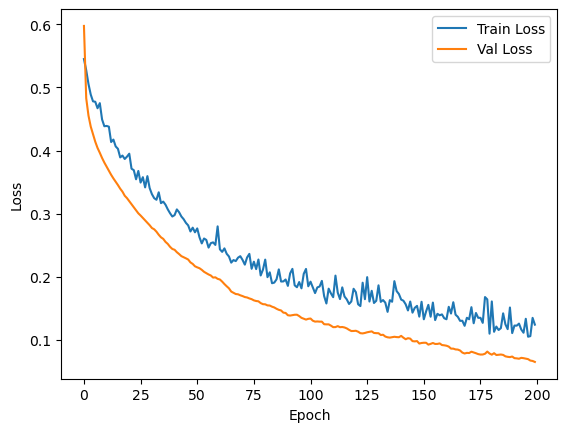

In [8]:
model= TSMixer(
    sequence_length=sequence_length,
    prediction_length=prediction_length,
    input_channels=input_channels,
    output_channels=output_channels,
)

best_model, curves, test_loss,test_dataset  = train_tsmixer(
    model,
    X_torch,
    Y_torch,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    epochs=200,
    batch_size=16,
    lr=1e-3,
    device="cpu"  # or "cpu"
)

plt.plot(curves[0], label='Train Loss')
plt.plot(curves[1], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

(20, 9)


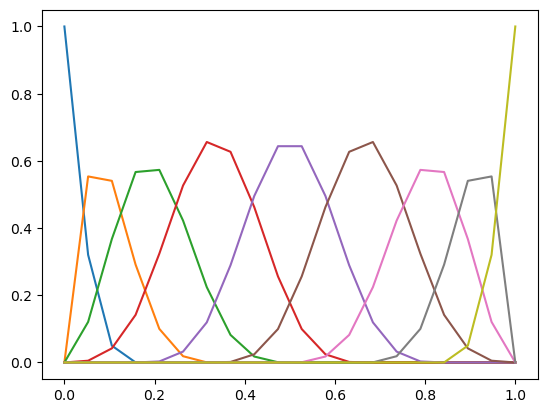

Epoch [10/200]: Train Loss: 0.0791, Val Loss: 0.3480
Epoch [20/200]: Train Loss: 0.0524, Val Loss: 0.2618
Epoch [30/200]: Train Loss: 0.0475, Val Loss: 0.2314
Epoch [40/200]: Train Loss: 0.0234, Val Loss: 0.1941
Epoch [50/200]: Train Loss: 0.0293, Val Loss: 0.2041
Epoch [60/200]: Train Loss: 0.0471, Val Loss: 0.1985
Epoch [70/200]: Train Loss: 0.0364, Val Loss: 0.1714
Epoch [80/200]: Train Loss: 0.0278, Val Loss: 0.2028
Epoch [90/200]: Train Loss: 0.0319, Val Loss: 0.1423
Epoch [100/200]: Train Loss: 0.0214, Val Loss: 0.1628
Epoch [110/200]: Train Loss: 0.0349, Val Loss: 0.1783
Epoch [120/200]: Train Loss: 0.0241, Val Loss: 0.1874
Epoch [130/200]: Train Loss: 0.0260, Val Loss: 0.1507
Epoch [140/200]: Train Loss: 0.0228, Val Loss: 0.2159
Epoch [150/200]: Train Loss: 0.0345, Val Loss: 0.1586
Epoch [160/200]: Train Loss: 0.0266, Val Loss: 0.1657
Epoch [170/200]: Train Loss: 0.0251, Val Loss: 0.1560
Epoch [180/200]: Train Loss: 0.0169, Val Loss: 0.1290
Epoch [190/200]: Train Loss: 0.0266, 

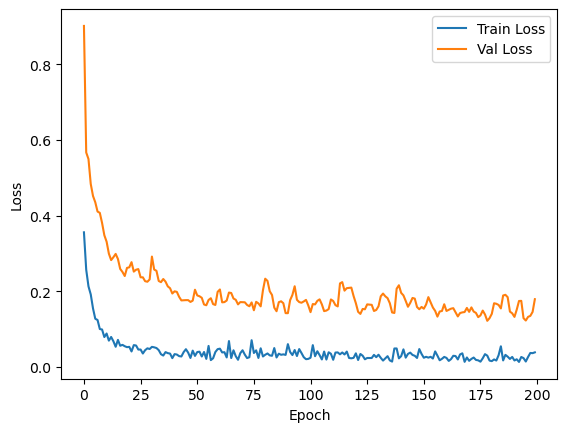

In [9]:
from timeview.basis import BSplineBasis
B=9
t=ts[0]

# Flatten all time arrays together

bspline=BSplineBasis(n_basis=B,t_range=(t[0],t[-1]))
Phis = list(bspline.get_all_matrices(np.array(ts))) # (D, sequence_length, B)
print(Phis[0].shape)
for i in range(B):
    plt.plot(t,Phis[0][:,i])
plt.show()

latent_model = TSMixer(
    sequence_length=sequence_length,   # same as time steps in X
    prediction_length=B, # number of spline coefficients to predict
    input_channels=input_channels,
    output_channels=output_channels,
)

best_latent_model, curves, test_loss,test_dataset = train_latent_tsmixer(
    latent_model,
    X_torch,
    Y_torch,
    Phis,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    epochs=200,
    batch_size=16,
    lr=0.01,
    device="cpu"  # or "cuda"
)

plt.plot(curves[0], label='Train Loss')
plt.plot(curves[1], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

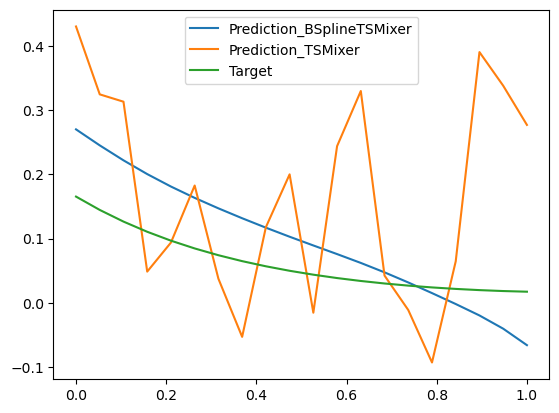

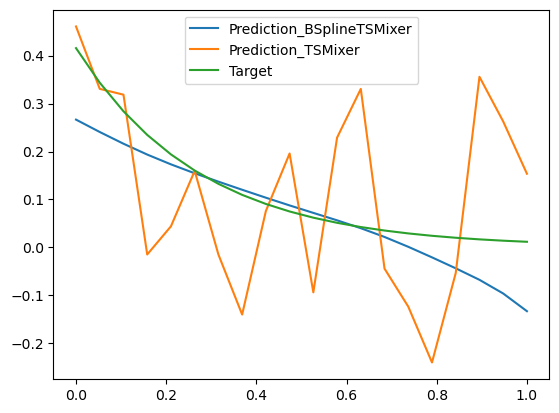

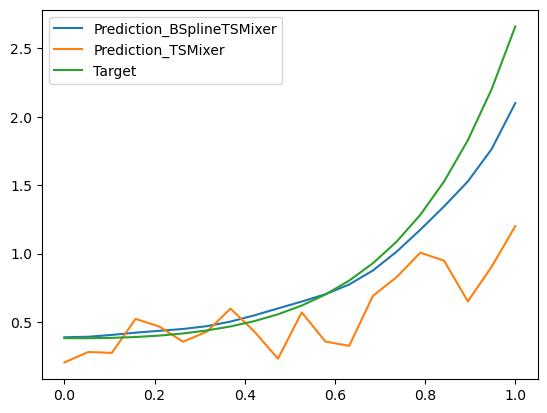

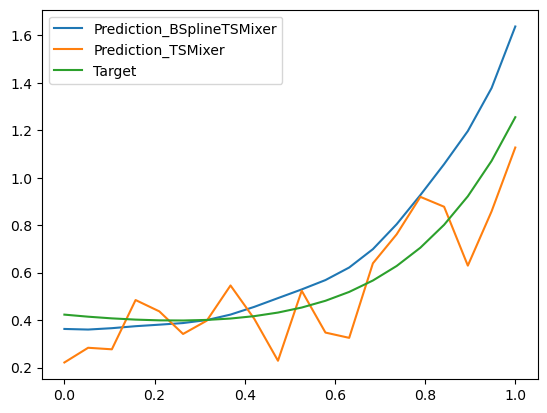

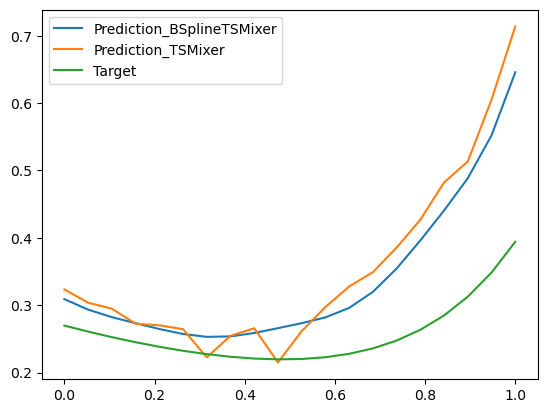

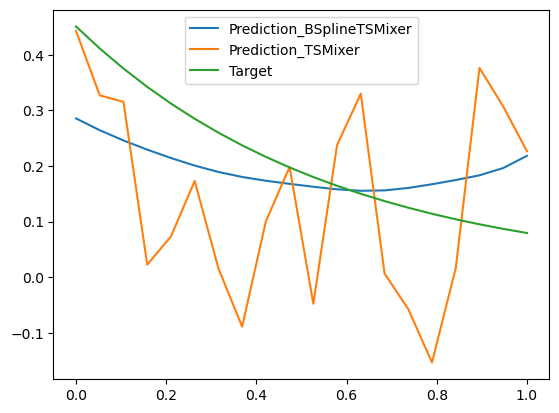

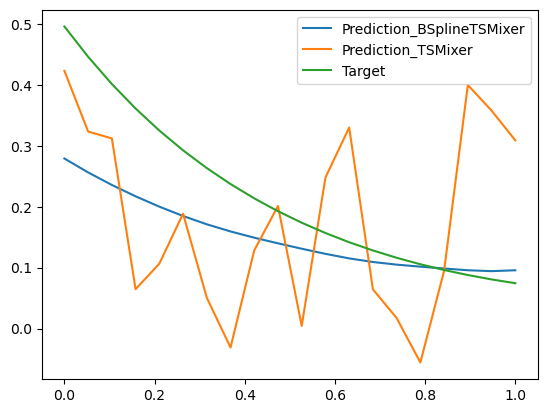

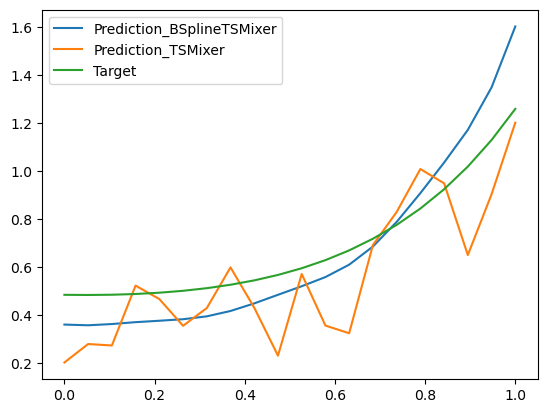

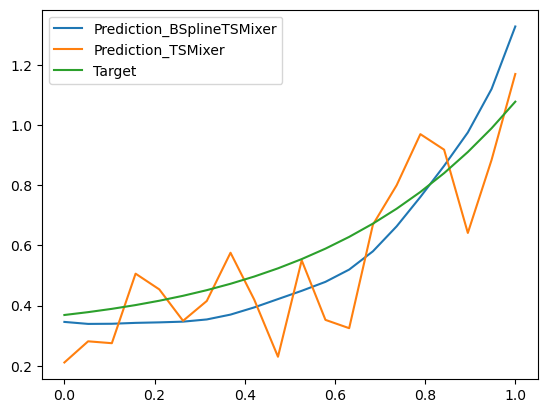

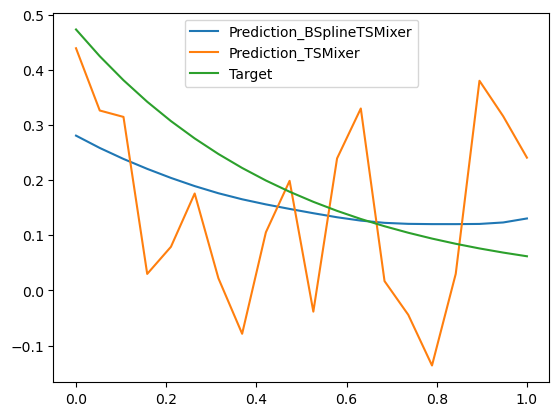

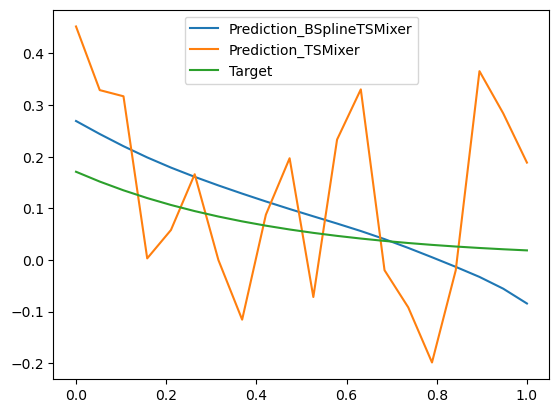

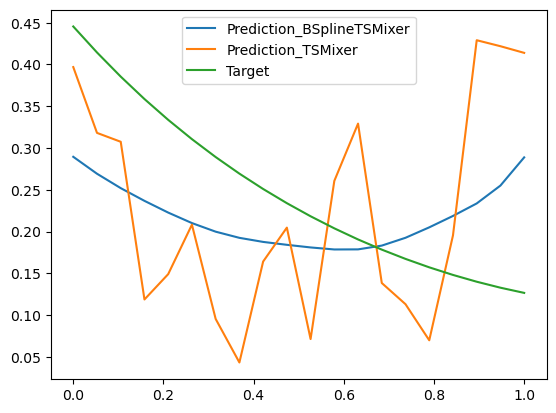

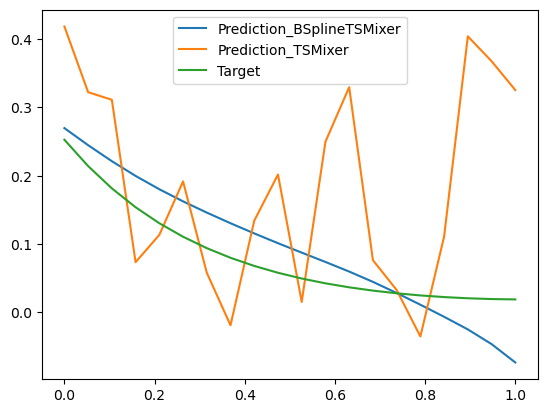

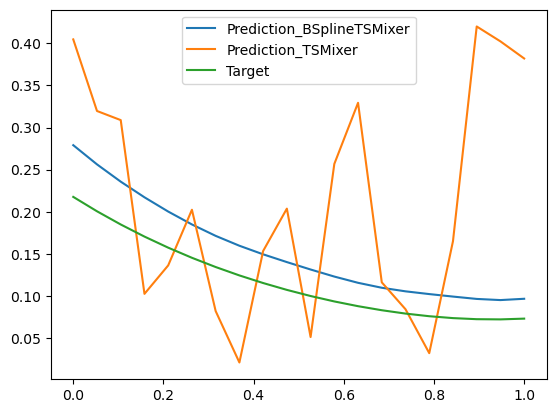

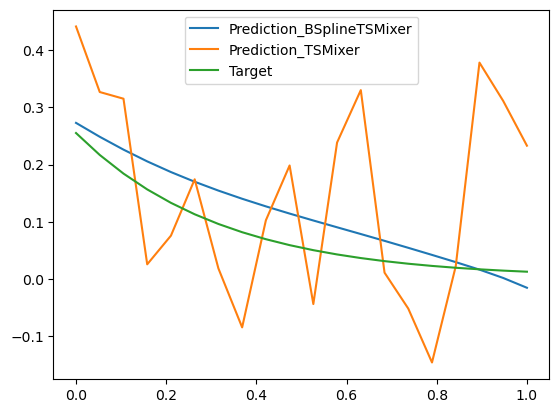

In [10]:
for idx in range(15):
    x_example=test_dataset.__getitem__(idx)[0]
    y_example=test_dataset.__getitem__(idx)[1]

    best_latent_model.eval()
    with torch.no_grad():
        h_pred = latent_model(x_example.unsqueeze(0))
    y_pred=torch.matmul(torch.Tensor(Phis)[0],h_pred).flatten().detach().numpy()

    best_model.eval()
    with torch.no_grad():
        pred = best_model(x_example.unsqueeze(0))

    plt.plot(ts[0],y_pred,label='Prediction_BSplineTSMixer')
    plt.plot(ts[0], pred.squeeze().numpy(), label='Prediction_TSMixer')
    plt.plot(ts[0], y_example.squeeze().numpy(), label='Target')
    plt.legend()
    plt.show()